# Autoencoder + Transformer Hybrid Model with SHAP Analysis

In [6]:
# Import Required Libraries
# Ensure TensorFlow is installed in your environment: pip install tensorflow numpy pandas scikit-learn matplotlib seaborn shap
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import shap

## Step 1: Data Loading

In [7]:
# Column names for NSL-KDD dataset
c_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "labels", "difficulty_degree"
]

# Load training and testing datasets
train = pd.read_csv("data/KDDTrain+.txt", names=c_names)
test = pd.read_csv("data/KDDTest+.txt", names=c_names)

## Step 2: Data Preprocessing

In [8]:
# Drop 'difficulty_degree' column as it does not add value
del train["difficulty_degree"]
del test["difficulty_degree"]

# Convert categorical features to numerical
categorical_features = ["protocol_type", "service", "flag"]

for col in categorical_features:
    train[col] = train[col].astype("category").cat.codes
    test[col] = test[col].astype("category").cat.codes

# Map 'labels' column to binary classes (1 for 'normal', 0 for 'attack')
train["labels"] = train["labels"].apply(lambda x: 1 if x == "normal" else 0)
test["labels"] = test["labels"].apply(lambda x: 1 if x == "normal" else 0)

# Separate features and labels
X_train = train.drop("labels", axis=1)
y_train = train["labels"]
X_test = test.drop("labels", axis=1)
y_test = test["labels"]

# Normalize numerical features
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Split training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

## Step 3: Define Autoencoder + Transformer Hybrid Model

In [9]:
# Autoencoder Component
def build_autoencoder(input_dim):
    inputs = keras.Input(shape=(input_dim,))
    encoded = layers.Dense(128, activation="relu")(inputs)
    encoded = layers.Dense(64, activation="relu")(encoded)
    encoded = layers.Dense(32, activation="relu")(encoded)
    decoded = layers.Dense(64, activation="relu")(encoded)
    decoded = layers.Dense(128, activation="relu")(decoded)
    outputs = layers.Dense(input_dim, activation="sigmoid")(decoded)
    autoencoder = keras.Model(inputs, outputs, name="autoencoder")
    encoder = keras.Model(inputs, encoded, name="encoder")
    return autoencoder, encoder

# Transformer Component
def build_transformer(input_shape):
    inputs = keras.Input(shape=(input_shape,))
    x = tf.expand_dims(inputs, axis=1)  # Add sequence dimension
    x = layers.Dense(32, activation="relu")(x)
    for _ in range(2):
        x1 = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
        x1 = layers.Add()([x, x1])
        x1 = layers.LayerNormalization()(x1)
        x2 = layers.Dense(32, activation="relu")(x1)
        x2 = layers.Dropout(0.3)(x2)
        x = layers.Add()([x1, x2])
        x = layers.LayerNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs, name="transformer")
    return model

# Combine Autoencoder and Transformer
input_dim = x_train.shape[1]
autoencoder, encoder = build_autoencoder(input_dim)
transformer = build_transformer(32)  # Latent dimension from encoder

# Compile Autoencoder
autoencoder.compile(optimizer="adam", loss="mse")
print("Training Autoencoder...")
autoencoder.fit(x_train, x_train, epochs=20, batch_size=64, validation_data=(x_val, x_val))

# Encode Features
encoded_x_train = encoder.predict(x_train)
encoded_x_val = encoder.predict(x_val)
encoded_x_test = encoder.predict(X_test)

# Compile Transformer
transformer.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
print("Training Transformer...")
history = transformer.fit(encoded_x_train, y_train, epochs=50, batch_size=64, validation_data=(encoded_x_val, y_val))

ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.ops`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


## Step 4: Evaluate the Model

In [ ]:
# Evaluate on the test set
test_loss, test_accuracy = transformer.evaluate(encoded_x_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

705/705 [==============================] - 4s 5ms/step - loss: 1.4489 - accuracy: 0.7923
Test Loss: 1.4489054679870605, Test Accuracy: 0.7922728657722473


In [ ]:
# Rebuild transformer to accept full input dimension
input_dim = x_train.shape[1]

def build_transformer_raw(input_shape):
    inputs = keras.Input(shape=(input_shape,))
    x = tf.expand_dims(inputs, axis=1)  # Add sequence dimension
    x = layers.Dense(32, activation="relu")(x)
    for _ in range(2):
        x1 = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
        x1 = layers.Add()([x, x1])
        x1 = layers.LayerNormalization()(x1)
        x2 = layers.Dense(32, activation="relu")(x1)
        x2 = layers.Dropout(0.3)(x2)
        x = layers.Add()([x1, x2])
        x = layers.LayerNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs, name="transformer_raw")
    return model

# Build and compile the model
transformer_raw = build_transformer_raw(input_dim)
transformer_raw.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train
history_raw = transformer_raw.fit(x_train, y_train, epochs=50, batch_size=64, validation_data=(x_val, y_val))

# Evaluate
test_loss_raw, test_acc_raw = transformer_raw.evaluate(X_test, y_test)
print(f"Transformer-Only Test Accuracy: {test_acc_raw}")


NameError: name 'x_train' is not defined

## Step 5: Visualizations

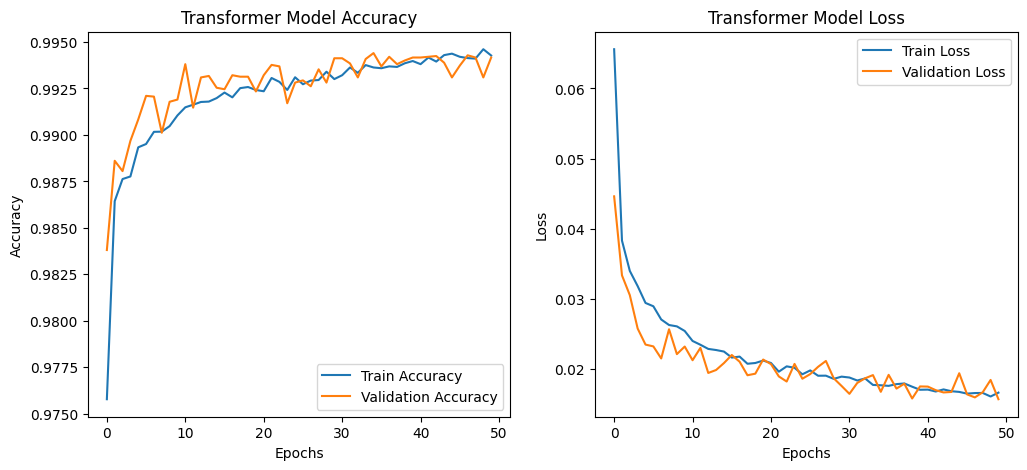

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Transformer Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Transformer Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

705/705 [==============================] - 4s 5ms/step


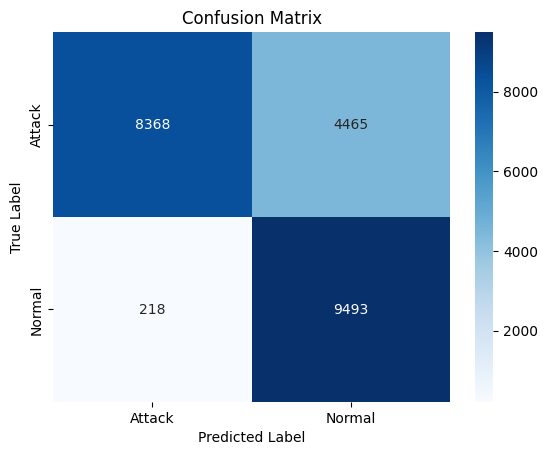

              precision    recall  f1-score   support

      Attack       0.97      0.65      0.78     12833
      Normal       0.68      0.98      0.80      9711

    accuracy                           0.79     22544
   macro avg       0.83      0.81      0.79     22544
weighted avg       0.85      0.79      0.79     22544



In [ ]:
# Confusion Matrix
y_pred = (transformer.predict(encoded_x_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Attack", "Normal"], yticklabels=["Attack", "Normal"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=["Attack", "Normal"]))

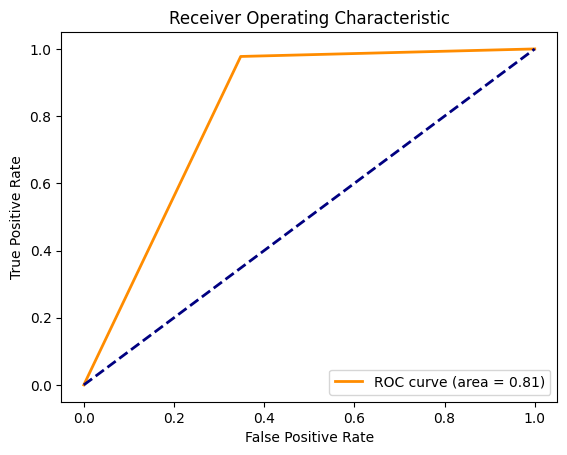

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.title("Receiver Operating Characteristic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

## Step 6: SHAP Analysis

In [ ]:
# SHAP Analysis with Partial Data
import shap

# Select a subset of the data for SHAP analysis
subset_size = 100  # Adjust the number of samples as needed
X_test_subset = X_test[:subset_size]
x_train_subset = x_train[:subset_size]

# Initialize the SHAP explainer using the subset of training data
explainer = shap.Explainer(transformer.predict, x_train_subset)

# Generate SHAP values for the test subset
shap_values = explainer(X_test_subset)

# Define feature names explicitly as a list
feature_names = list(train.columns[:-1])  # Convert to list for SHAP compatibility

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test_subset, feature_names=feature_names)
plt.savefig("visualization/shap_summary_plot.png")
plt.close()

# SHAP Decision Plot
shap.decision_plot(
    shap_values.base_values[0], 
    shap_values.values[0], 
    feature_names=feature_names
)
plt.savefig("visualization/shap_decision_plot.png")
plt.close()

# SHAP Force Plot (Single Instance)
shap.force_plot(
    shap_values.base_values[0], 
    shap_values.values[0], 
    X_test_subset[0], 
    feature_names=feature_names, 
    matplotlib=True
)
shap.save_html(
    "visualization/shap_force_plot.html", 
    shap.force_plot(
        shap_values.base_values[0], 
        shap_values.values[0], 
        X_test_subset[0], 
        feature_names=feature_names
    )
)


InvalidArgumentError: Graph execution error:

Detected at node 'transformer/dense_6/Tensordot/MatMul' defined at (most recent call last):
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/traitlets/config/application.py", line 1075, in launch_instance
      app.start()
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 739, in start
      self.io_loop.start()
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
      await result
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_6279/856657796.py", line 13, in <module>
      shap_values = explainer(X_test_subset)
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/shap/explainers/_permutation.py", line 79, in __call__
      return super().__call__(
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/shap/explainers/_explainer.py", line 267, in __call__
      row_result = self.explain_row(
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/shap/explainers/_permutation.py", line 137, in explain_row
      outputs = fm(masks, zero_index=0, batch_size=batch_size)
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/shap/utils/_masked_model.py", line 59, in __call__
      return self._delta_masking_call(masks, zero_index=zero_index, batch_size=batch_size)
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/shap/utils/_masked_model.py", line 205, in _delta_masking_call
      outputs = self.model(*subset_masked_inputs)
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/shap/models/_model.py", line 28, in __call__
      out = self.inner_model(*args)
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/keras/src/engine/training.py", line 2554, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/keras/src/engine/training.py", line 2341, in predict_function
      return step_function(self, iterator)
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/keras/src/engine/training.py", line 2327, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/keras/src/engine/training.py", line 2315, in run_step
      outputs = model.predict_step(data)
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/keras/src/engine/training.py", line 2283, in predict_step
      return self(x, training=False)
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/keras/src/layers/core/dense.py", line 244, in call
      outputs = tf.tensordot(inputs, self.kernel, [[rank - 1], [0]])
Node: 'transformer/dense_6/Tensordot/MatMul'
Matrix size-incompatible: In[0]: [32,41], In[1]: [32,32]
	 [[{{node transformer/dense_6/Tensordot/MatMul}}]] [Op:__inference_predict_function_568257]